<a href="https://colab.research.google.com/github/auspicious0/anxiety/blob/main/%EB%A1%9C%EC%A7%80%EC%8A%A4%ED%8B%B1%ED%9A%8C%EA%B7%80_anxiety.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#패키지 부착, 출력 그래프의 크기를 설정
install.packages(c("tidyverse","data.table"))
library(tidyverse)
library(data.table)
library(repr)

options(repr.plot.width=7,repr.plot.height=7)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [ ]:
#데이터 취득과 정제
#https://www.kaggle.com/datasets/shahzadahmad0402/depression-and-anxiety-data/data?select=depression_anxiety_data.csv
#https://drive.google.com/file/d/1QbSP_vPsddHP4EdKhEFyealseK5b2pyg/view?usp=sharing
system("gdown --id 1QbSP_vPsddHP4EdKhEFyealseK5b2pyg")
system("ls",TRUE)


[1] "depression_anxiety_data.csv" "sample_data"

In [ ]:
DF<-fread("depression_anxiety_data.csv",header=T,encoding="UTF-8")%>%as_tibble()
DF%>%show()

# A tibble: 783 × 19
      id school_year   age gender   bmi who_bmi    phq_score depression_severity
   <int>       <int> <int> <chr>  <dbl> <chr>          <int> <chr>              
 1     1           1    19 male    33.3 Class I O…         9 Mild               
 2     2           1    18 male    19.8 Normal             8 Mild               
 3     3           1    19 male    25.1 Overweight         8 Mild               
 4     4           1    18 female  23.7 Normal            19 Moderately severe  
 5     5           1    18 male    25.6 Overweight         6 Mild               
 6     6           1    18 male    22.1 Normal             3 None-minimal       
 7     7           1    18 male    22.4 Normal             6 Mild               
 8     8           1    19 male    20.5 Normal             4 None-minimal       
 9     9           1    20 male    21.2 Normal            11 Moderate           
10    10           1    19 male    24.5 Normal             6 Mild               
# ℹ 773

In [ ]:
DF%>%str() #나이(age), 학년(school_year), 성별(gender), 육체적 능력(bmi, who_bmi, phq_score)과 불안과의 관계를 로지스틱회귀로 분석
           #육체적 능력(phq_score)에 따른 불안 정도(gad_score)를 선형회귀로 분석

tibble [783 × 19] (S3: tbl_df/tbl/data.frame)
 $ id                  : int [1:783] 1 2 3 4 5 6 7 8 9 10 ...
 $ school_year         : int [1:783] 1 1 1 1 1 1 1 1 1 1 ...
 $ age                 : int [1:783] 19 18 19 18 18 18 18 19 20 19 ...
 $ gender              : chr [1:783] "male" "male" "male" "female" ...
 $ bmi                 : num [1:783] 33.3 19.8 25.1 23.7 25.6 ...
 $ who_bmi             : chr [1:783] "Class I Obesity" "Normal" "Overweight" "Normal" ...
 $ phq_score           : int [1:783] 9 8 8 19 6 3 6 4 11 6 ...
 $ depression_severity : chr [1:783] "Mild" "Mild" "Mild" "Moderately severe" ...
 $ depressiveness      : logi [1:783] FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ suicidal            : logi [1:783] FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ depression_diagnosis: logi [1:783] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ depression_treatment: logi [1:783] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ gad_score           : int [1:783] 11 5 6 15 14 2 4 9 8 4 ...
 $ anxiety_sev

In [ ]:
#사용할 변수들의 범주형 확인

DF$school_year %>% unique()
DF$age %>% unique()
DF$gender %>% unique()
DF$who_bmi %>% unique()
DF$anxiety_severity %>% unique()
DF$anxiousness%>% unique()

#삭제할 변수는 id, depression_severity, depressiveness, suicidal, depression_diagnosis,depression_treatment, anxiety_diagnosis, anxiety_treatment, sleepiness

[1] 1 2 3 4

[1] 19 18 20 21 24 23 26 22 31 25 28 27 30

[1] "male"   "female"

[1] "Class I Obesity"   "Normal"            "Overweight"       
[4] "Not Availble"      "Class III Obesity" "Underweight"      
[7] "Class II Obesity"

[1] "Moderate"     "Mild"         "Severe"       "None-minimal" "0"

[1]  TRUE FALSE    NA

In [ ]:
#삭제할 변수는 id, depression_severity, depressiveness, suicidal, depression_diagnosis,depression_treatment, anxiety_diagnosis, anxiety_treatment, sleepiness
#age는 10개 이상의 값이 있어 범주형으로 선택하지 않음.
DF<-select(DF,-id, - depression_severity, -depressiveness, -suicidal, -depression_diagnosis,-depression_treatment ,-anxiety_diagnosis, -anxiety_treatment,-sleepiness)%>%
  mutate_at(c("school_year","gender","who_bmi","anxiety_severity","anxiousness"),factor)

In [ ]:
#변환이 잘 되었는지 확인
DF%>%str()
DF%>%show()

tibble [783 × 10] (S3: tbl_df/tbl/data.frame)
 $ school_year     : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ age             : int [1:783] 19 18 19 18 18 18 18 19 20 19 ...
 $ gender          : Factor w/ 2 levels "female","male": 2 2 2 1 2 2 2 2 2 2 ...
 $ bmi             : num [1:783] 33.3 19.8 25.1 23.7 25.6 ...
 $ who_bmi         : Factor w/ 7 levels "Class I Obesity",..: 1 4 6 4 6 4 4 4 4 4 ...
 $ phq_score       : int [1:783] 9 8 8 19 6 3 6 4 11 6 ...
 $ gad_score       : int [1:783] 11 5 6 15 14 2 4 9 8 4 ...
 $ anxiety_severity: Factor w/ 5 levels "0","Mild","Moderate",..: 3 2 2 5 3 4 4 2 2 4 ...
 $ anxiousness     : Factor w/ 2 levels "FALSE","TRUE": 2 1 1 2 2 1 1 1 1 1 ...
 $ epworth_score   : int [1:783] 7 14 6 11 3 2 3 5 7 9 ...
 - attr(*, ".internal.selfref")=<externalptr> 
# A tibble: 783 × 10
   school_year   age gender   bmi who_bmi   phq_score gad_score anxiety_severity
   <fct>       <int> <fct>  <dbl> <fct>         <int>     <int> <fct>           

 school_year      age           gender         bmi       
 1:227       Min.   :18.00   female:350   Min.   :14.88  
 2:165       1st Qu.:19.00   male  :333   1st Qu.:20.90  
 3:130       Median :20.00                Median :22.99  
 4:161       Mean   :20.17                Mean   :23.17  
             3rd Qu.:21.00                3rd Qu.:25.25  
             Max.   :24.00                Max.   :31.60  
                                                         
              who_bmi      phq_score       gad_score          anxiety_severity
 Class I Obesity  :  8   Min.   : 0.00   Min.   : 0.000   0           :  0    
 Class II Obesity :  0   1st Qu.: 4.00   1st Qu.: 3.000   Mild        :277    
 Class III Obesity:  0   Median : 6.00   Median : 6.000   Moderate    :105    
 Normal           :470   Mean   : 6.46   Mean   : 6.347   None-minimal:264    
 Not Availble     :  0   3rd Qu.: 9.00   3rd Qu.: 9.000   Severe      : 37    
 Overweight       :174   Max.   :16.00   Max.   :18.000       


FALSE 
 6830 

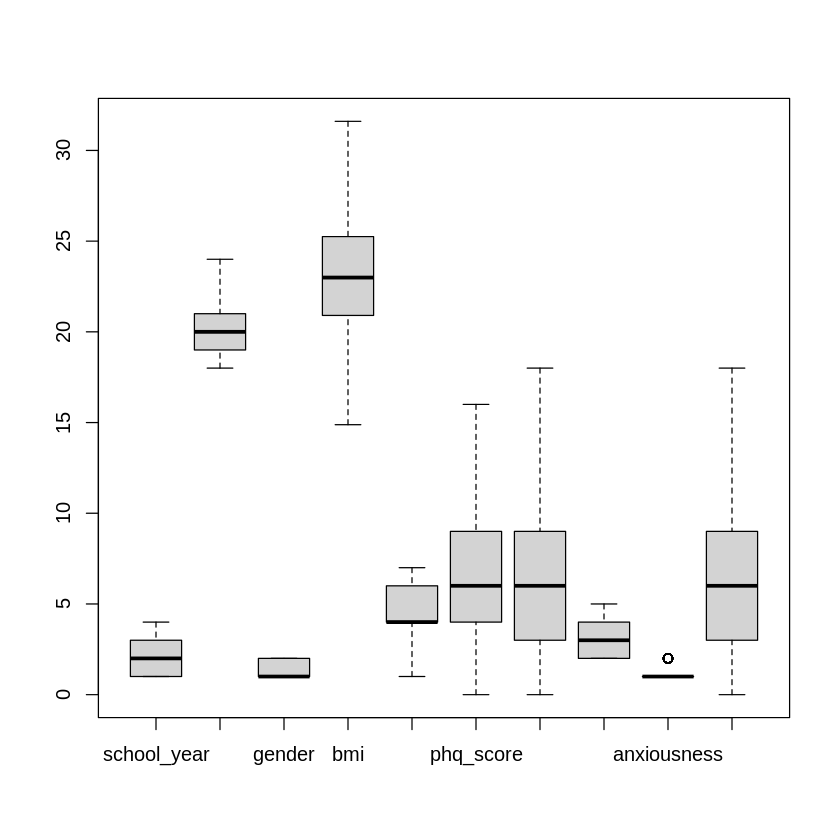

In [ ]:
#결측값, 이상값 처리를 위한 확인절차
DF%>%summary()
table(is.na(DF))
boxplot(DF)


FALSE 
 7710 

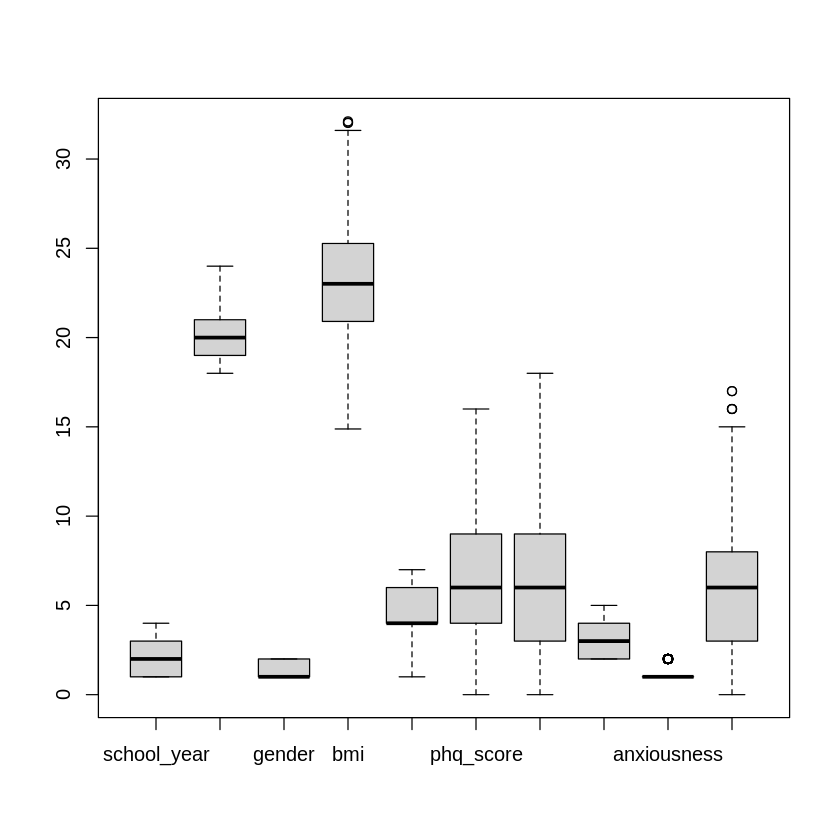

In [ ]:
# 결측값은 불안(anxiousness)에서 대략 700개 이상의 데이터 중 6개, 수면도(epworth_score)에서 8개 이므로 결과에 큰 영향을 미치지 않을 것으로
#판단했기 때문에 삭제해도 무리가 없을 것으로 생각한다.
#이상값 처리를 진행한다.

DF<-na.omit(DF)
table(is.na(DF))
# 이상치 및 결측값 처리 함수
calculate_outliers <- function(data, column_name) {
  iqr_value <- IQR(data[[column_name]])
  upper_limit <- quantile(data[[column_name]], 0.75) + 1.5 * iqr_value
  lower_limit <- quantile(data[[column_name]], 0.25) - 1.5 * iqr_value

  data[[column_name]] <- ifelse(data[[column_name]] < lower_limit | data[[column_name]] > upper_limit, NA, data[[column_name]])

  return(data)
}

# 이상치 및 결측값 처리 및 결과에 대한 상자그림 그리기
DF <- calculate_outliers(DF, "age")
DF <- calculate_outliers(DF, "phq_score")
DF <- calculate_outliers(DF, "bmi")
DF <- calculate_outliers(DF, "gad_score")
DF <- calculate_outliers(DF, "epworth_score")
DF <- na.omit(DF)
boxplot(DF)

In [ ]:
#카이제곱 검정을 통해 나이(age), 학년(school_year), 성별(gender), 육체적 능력(bmi, who_bmi, phq_score)과 불안(anxiousness)과의 연관관계를 분석
install.packages("gmodels")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
print("불안(anxiousness)과 나이(age)와의 연관관계 분석 ")
gmodels::CrossTable(DF$anxiousness,DF$age,chisq=T,expected=T,prop.r=F,prop.c=F)

[1] "불안(anxiousness)과 나이(age)와의 연관관계 분석 "


Warning message in chisq.test(t, correct = FALSE, ...):
“Chi-squared approximation may be incorrect”



 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
| Chi-square contribution |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  683 

 
               | DF$age 
DF$anxiousness |        18 |        19 |        20 |        21 |        22 |        23 |        24 | Row Total | 
---------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
         FALSE |        80 |       122 |       100 |       126 |        74 |        27 |        12 |       541 | 
               |    79.209 |   133.864 |   102.972 |   114.061 |    74.457 |    24.555 |    11.881 |           | 
               |     0.008 |     1.051 |     0.086 |     1.250 |     0.003 |     0.243 |     0.001 |           | 
               |     0.117 |     0.179 |     0.146 |     0.184 |     0.108 |     0.040 |     0.018 |           | 
---------------|-----------|-----------|-----------|-----------

#대학 학생들 대상 데이터다 보니 상대적으로 25세 이상 학생이 적어 효과적인 데이터 분석이 되지 않고 있다고 판단.

# 따라서 나이가 효과적인 변수가 되지 않는 것일 수도 있다고 생각하여 학년으로 바꾸어 다시 카이제곱 분석


In [ ]:
print("불안(anxiousness)과 학년(school_year)와의 연관관계 분석 ")
gmodels::CrossTable(DF$anxiousness,DF$school_year,chisq=T,expected=T,prop.r=F,prop.c=F)

[1] "불안(anxiousness)과 학년(school_year)와의 연관관계 분석 "

 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
| Chi-square contribution |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  683 

 
               | DF$school_year 
DF$anxiousness |         1 |         2 |         3 |         4 | Row Total | 
---------------|-----------|-----------|-----------|-----------|-----------|
         FALSE |       172 |       123 |       106 |       140 |       541 | 
               |   179.805 |   130.695 |   102.972 |   127.527 |           | 
               |     0.339 |     0.453 |     0.089 |     1.220 |           | 
               |     0.252 |     0.180 |     0.155 |     0.205 |           | 
---------------|-----------|-----------|-----------|-----------|-----------|
          TRUE |        55 |        42 |        24 |        21 |       142 | 
               |    47.195 |    34.305 |    27.028 |    33.473 |  

#1학년 학생이 전체 데이터 중 1/3을 차지하기 때문에 분석이 제대로 이루어지지 않는 것 같다고 생각한다.


#불안감의 정도를 각 학년별로 비율적으로 분석해도 크게 유의미한 결과는 아닌 것으로 확인.  

In [ ]:
print("불안(anxiousness)과 성별(gender)와의 연관관계 분석 ")
gmodels::CrossTable(DF$anxiousness,DF$gender,chisq=T,expected=T,prop.r=F,prop.c=F)

[1] "불안(anxiousness)과 학년(gender)와의 연관관계 분석 "

 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
| Chi-square contribution |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  683 

 
               | DF$gender 
DF$anxiousness |    female |      male | Row Total | 
---------------|-----------|-----------|-----------|
         FALSE |       256 |       285 |       541 | 
               |   277.233 |   263.767 |           | 
               |     1.626 |     1.709 |           | 
               |     0.375 |     0.417 |           | 
---------------|-----------|-----------|-----------|
          TRUE |        94 |        48 |       142 | 
               |    72.767 |    69.233 |           | 
               |     6.196 |     6.512 |           | 
               |     0.138 |     0.070 |           | 
---------------|-----------|-----------|-----------|
  Column Total |       350 |       333 |       683 | 

#여성이 남성보다 다소 더 불안을 느끼는 것으로 확인된다.

In [ ]:
print("불안(anxiousness)과 육체적 능력(who_bmi)와의 연관관계 분석 ")
gmodels::CrossTable(DF$anxiousness,DF$who_bmi,chisq=T,expected=T,prop.r=F,prop.c=F)

[1] "불안(anxiousness)과 육체적 능력(who_bmi)와의 연관관계 분석 "


Warning message in chisq.test(t, correct = FALSE, ...):
“Chi-squared approximation may be incorrect”



 
   Cell Contents
|-------------------------|
|                       N |
|              Expected N |
| Chi-square contribution |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  683 

 
               | DF$who_bmi 
DF$anxiousness | Class I Obesity |          Normal |      Overweight |     Underweight |       Row Total | 
---------------|-----------------|-----------------|-----------------|-----------------|-----------------|
         FALSE |               5 |             374 |             138 |              24 |             541 | 
               |           6.337 |         372.284 |         137.824 |          24.555 |                 | 
               |           0.282 |           0.008 |           0.000 |           0.013 |                 | 
               |           0.007 |           0.548 |           0.202 |           0.035 |                 | 
---------------|-----------------|-----------------|-----------------|-----------------|-------

#절대다수가 normal 클레스에 있기 때문에 효과적인 분석이 이루어지지 않는 것으로 보인다. 따라서 해당 주제로 프로젝트를 계속 진행해 나가야 할지 고민된다.

#우선 glm을 통해 상관관계를 파악한 후 다시 결정하기로 한다.


In [ ]:
#본격적인 로지스틱 회귀 분석을 위해 패키지를 설치한다. 데이터의 80페센트를 학습 데이터(train)
#나머지는 테스트 데이터(test)로 분리한다.
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘proxy’, ‘iterators’, ‘Rcpp’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘e1071’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




In [ ]:
index<-caret::createDataPartition(y=DF$anxiousness,p=0.8,list=FALSE)
train<-DF[index,]
test<-DF[-index,]

train%>%show()
test%>%show()

# A tibble: 547 × 10
   school_year   age gender   bmi who_bmi   phq_score gad_score anxiety_severity
   <fct>       <int> <fct>  <dbl> <fct>         <int>     <int> <fct>           
 1 1              18 male    19.8 Normal            8         5 Mild            
 2 1              18 male    22.1 Normal            3         2 None-minimal    
 3 1              19 male    20.5 Normal            4         9 Mild            
 4 1              20 male    21.2 Normal           11         8 Mild            
 5 1              19 male    24.5 Normal            6         4 None-minimal    
 6 1              18 male    23.1 Normal            2         2 None-minimal    
 7 1              18 male    22.8 Normal           10        11 Moderate        
 8 1              18 male    19.6 Normal            6         1 None-minimal    
 9 1              18 male    20.8 Normal            8         1 None-minimal    
10 1              18 male    27.3 Overweig…         9         2 None-minimal    
# ℹ 537

In [ ]:
print("glm model m")

m <- glm(formula = anxiousness ~ ., data = train, family = "binomial")
summary(m)


[1] "glm model m"


Warning message:
“glm.fit: algorithm did not converge”



Call:
glm(formula = anxiousness ~ ., family = "binomial", data = train)

Coefficients:
                               Estimate Std. Error z value Pr(>|z|)
(Intercept)                  -2.657e+01  4.241e+05   0.000    1.000
school_year2                  2.108e-13  4.227e+04   0.000    1.000
school_year3                 -2.460e-14  5.086e+04   0.000    1.000
school_year4                 -1.996e-14  5.723e+04   0.000    1.000
age                           4.524e-14  1.426e+04   0.000    1.000
gendermale                   -3.389e-14  3.303e+04   0.000    1.000
bmi                          -8.535e-14  9.785e+03   0.000    1.000
who_bmiNormal                -9.306e-13  1.567e+05   0.000    1.000
who_bmiOverweight            -6.470e-13  1.377e+05   0.000    1.000
who_bmiUnderweight           -1.254e-12  1.951e+05   0.000    1.000
phq_score                    -4.645e-14  5.413e+03   0.000    1.000
gad_score                     5.977e-14  1.210e+04   0.000    1.000
anxiety_severityModerate    

#“glm.fit: algorithm did not converge” 해당 오류가 발생했습니다.

#해당 오류는 수렴 문제로 모델 복잡성, 다중공선성등의 문제로 발생합니다.

#해당 문제의 경우 다중공선성 및 모델 복잡성으로 수렴이 되지 않는 문제가 발생한다고 하는데 이 경우 어떤 문제가 있는지 판단하기 힘듭니다.

#우선 이를 해결하기 위해 최대 반복 횟수를 증가시켜 보았습니다. 즉 control = glm.control(maxit = 100)와 같이 maxit 매개변수를 증가시킨 것입니다. 또 모델을 단순화 해보기 위해 아래와 같이 시행해 보고자합니다.


In [ ]:
#다시 변수를 초기화 한 후 살펴보기
DF%>%str()


tibble [783 × 19] (S3: tbl_df/tbl/data.frame)
 $ id                  : int [1:783] 1 2 3 4 5 6 7 8 9 10 ...
 $ school_year         : int [1:783] 1 1 1 1 1 1 1 1 1 1 ...
 $ age                 : int [1:783] 19 18 19 18 18 18 18 19 20 19 ...
 $ gender              : chr [1:783] "male" "male" "male" "female" ...
 $ bmi                 : num [1:783] 33.3 19.8 25.1 23.7 25.6 ...
 $ who_bmi             : chr [1:783] "Class I Obesity" "Normal" "Overweight" "Normal" ...
 $ phq_score           : int [1:783] 9 8 8 19 6 3 6 4 11 6 ...
 $ depression_severity : chr [1:783] "Mild" "Mild" "Mild" "Moderately severe" ...
 $ depressiveness      : logi [1:783] FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ suicidal            : logi [1:783] FALSE FALSE FALSE TRUE FALSE FALSE ...
 $ depression_diagnosis: logi [1:783] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ depression_treatment: logi [1:783] FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ gad_score           : int [1:783] 11 5 6 15 14 2 4 9 8 4 ...
 $ anxiety_sev

In [ ]:
DF$gender %>% unique()
DF$depression_severity %>% unique()
DF$anxiety_severity %>% unique()


[1] "male"   "female"

[1] "Mild"              "Moderately severe" "None-minimal"     
[4] "Moderate"          NA                  "Severe"           
[7] "none"

[1] "Moderate"     "Mild"         "Severe"       "None-minimal" "0"

해당 변수로는 무엇을 이끌어내기 어려울 것으로 판단된다.


In [ ]:
#일단 계속해서 진행해 보려고 한다. 필요없는 설명변수를 제거해본다.“backward”방식사용
print("backward model mback")
mback <- step(m, direction = "backward")

[1] "backward model mback"
Start:  AIC=32
anxiousness ~ school_year + age + gender + bmi + who_bmi + phq_score + 
    gad_score + anxiety_severity + epworth_score



Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”


                   Df   Deviance AIC
- school_year       3 3.1730e-09  26
- who_bmi           3 3.1730e-09  26
- anxiety_severity  3 1.0563e-07  26
- age               1 3.1730e-09  30
- gender            1 3.1730e-09  30
- bmi               1 3.1730e-09  30
- phq_score         1 3.1730e-09  30
- gad_score         1 3.1730e-09  30
- epworth_score     1 3.1730e-09  30
<none>                3.1730e-09  32


Warning message:
“glm.fit: algorithm did not converge”



Step:  AIC=26
anxiousness ~ age + gender + bmi + who_bmi + phq_score + gad_score + 
    anxiety_severity + epworth_score



Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”


                   Df   Deviance AIC
- who_bmi           3 3.1730e-09  20
- anxiety_severity  3 1.0447e-07  20
- age               1 3.1730e-09  24
- gender            1 3.1730e-09  24
- bmi               1 3.1730e-09  24
- phq_score         1 3.1730e-09  24
- gad_score         1 3.1730e-09  24
- epworth_score     1 3.1730e-09  24
<none>                3.1730e-09  26


Warning message:
“glm.fit: algorithm did not converge”



Step:  AIC=20
anxiousness ~ age + gender + bmi + phq_score + gad_score + anxiety_severity + 
    epworth_score



Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”


                   Df   Deviance AIC
- anxiety_severity  3 1.0463e-07  14
- age               1 3.1730e-09  18
- gender            1 3.1730e-09  18
- bmi               1 3.1730e-09  18
- phq_score         1 3.1730e-09  18
- gad_score         1 3.1730e-09  18
- epworth_score     1 3.1730e-09  18
<none>                3.1730e-09  20


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=14
anxiousness ~ age + gender + bmi + phq_score + gad_score + epworth_score



Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                Df Deviance    AIC
- gender         1     0.00  12.00
- epworth_score  1     0.00  12.00
- bmi            1     0.00  12.00
- age            1     0.00  12.00
- phq_score      1     0.00  12.00
<none>                 0.00  14.00
- gad_score      1   411.64 423.64


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=12
anxiousness ~ age + bmi + phq_score + gad_score + epworth_score



Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


                Df Deviance    AIC
- epworth_score  1     0.00  10.00
- bmi            1     0.00  10.00
- phq_score      1     0.00  10.00
- age            1     0.00  10.00
<none>                 0.00  12.00
- gad_score      1   413.85 423.85


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=10
anxiousness ~ age + bmi + phq_score + gad_score



Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


            Df Deviance    AIC
- bmi        1     0.00   8.00
- age        1     0.00   8.00
- phq_score  1     0.00   8.00
<none>             0.00  10.00
- gad_score  1   422.79 430.79


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=8
anxiousness ~ age + phq_score + gad_score



Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


            Df Deviance   AIC
- age        1      0.0   6.0
- phq_score  1      0.0   6.0
<none>              0.0   8.0
- gad_score  1    423.3 429.3


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=6
anxiousness ~ phq_score + gad_score



Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


            Df Deviance    AIC
- phq_score  1     0.00   4.00
<none>             0.00   6.00
- gad_score  1   424.78 428.78


Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Step:  AIC=4
anxiousness ~ gad_score

            Df Deviance    AIC
<none>             0.00   4.00
- gad_score  1   557.27 559.27


In [ ]:
summary(mback)


Call:
glm(formula = anxiousness ~ gad_score, family = "binomial", data = train)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)   -395.4    50782.1  -0.008    0.994
gad_score       41.6     5355.8   0.008    0.994

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 5.5727e+02  on 546  degrees of freedom
Residual deviance: 1.0301e-07  on 545  degrees of freedom
AIC: 4

Number of Fisher Scoring iterations: 25


전혀 유의미하지 않다. 다른 자료를 찾기로 한다.
